## Final Project
In the final project we want to implement a custom training loop for a deep learning model in TensorFlow and Keras. The training loop should perform the following tasks:

1. Load the training and validation data.
2. Define the model architecture using Keras.
3. Compile the model with a loss function and an optimizer.
4. Train the model for a specified number of epochs, using a batch size of your choice.
5. Evaluate the model on the validation data after each epoch.
6. Plot the training and validation loss and accuracy curves using matplotlib.

**Assignment constraints:**

* You must use the TensorFlow 2.x API.
* You must use the Keras API to define the model architecture.
* You must use a custom training loop, rather than the `fit` method provided by Keras.
* You must use a GPU, if available, for training the model.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. Load the training and validation data
1.1. Use the TensorFlow Datasets to load the [Eurosat Dataset](https://www.tensorflow.org/datasets/catalog/eurosat).This dataset consist of satellite images from different types of zones\
You can check that this dataset has only one split `Train`. So create train/validation/test splits by using 70% of dataset as the train set, 15% for validation set and 15% for test set.

In [28]:
#Code Here
(train_ds, val_ds, test_ds), metadata = tfds.load('eurosat', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], as_supervised= True, with_info=True) # Code Here

2.2 Inspect dataset: extract number of classes in the dataset, class names, number of data in the dataset and use the `tfds` visualization tool to visualize some of the data

In [29]:
#Code Here
num_classes = metadata.features['label'].num_classes
get_label_name = metadata.features['label'].int2str
print(f"Number of classes in the dataset: {num_classes}")
for i in range(num_classes):
    print(f"class id {i} is {get_label_name(i)}")

Number of classes in the dataset: 10
class id 0 is AnnualCrop
class id 1 is Forest
class id 2 is HerbaceousVegetation
class id 3 is Highway
class id 4 is Industrial
class id 5 is Pasture
class id 6 is PermanentCrop
class id 7 is Residential
class id 8 is River
class id 9 is SeaLake


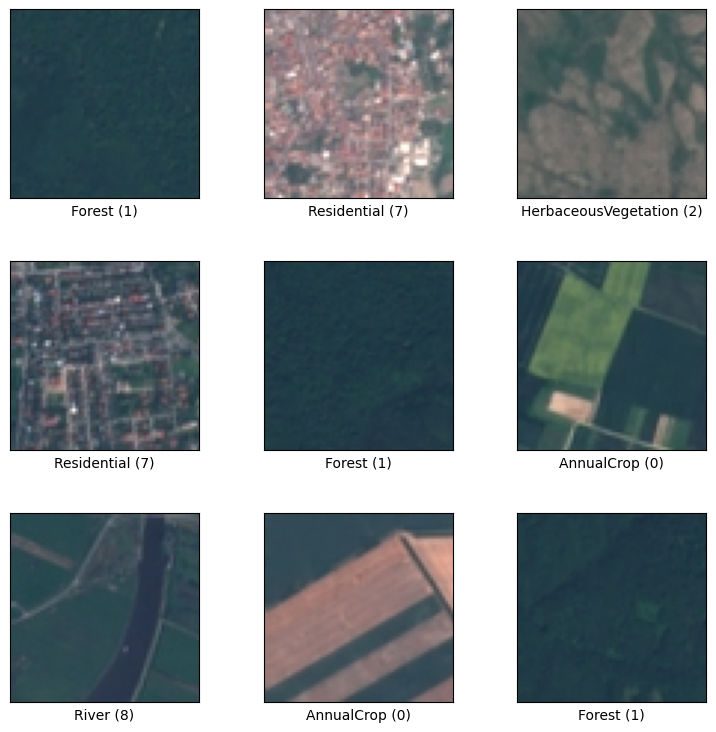

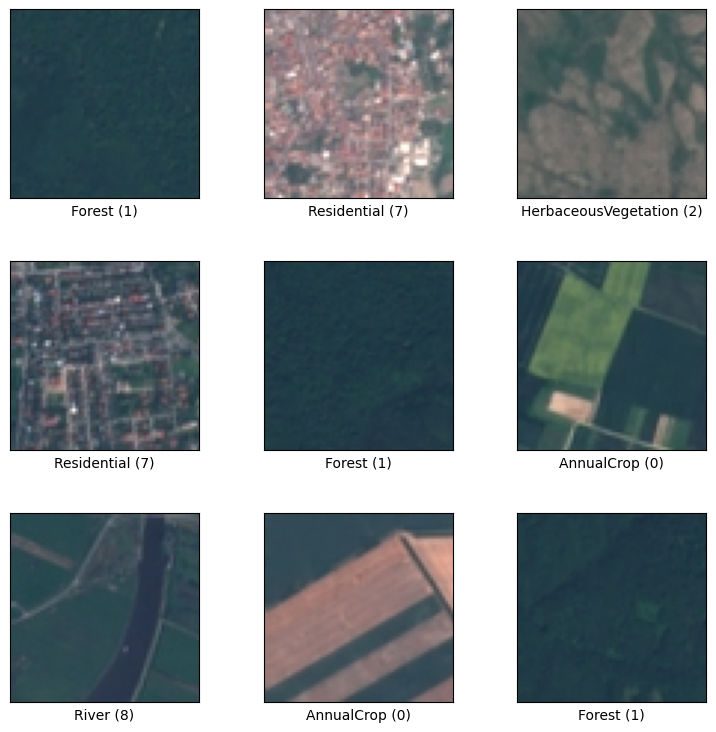

In [5]:
#Code Here
tfds.show_examples(train_ds, metadata)

1.3. write a function that resize images to `64x64` and rescale the pixels to be between `[0,1]`. Also employ a one-hot encoding for the labels. Then by using `map` method apply this preprocessing function to all splits: (use num_parallel_calls argument in map function to run the function faster)

In [30]:
def preprocess(image, label):
    #Code Here
    resized_image = tf.image.resize(image, (64, 64))
    rescaled_and_resized_image = tf.divide(resized_image, 255)
    encoded_label = tf.one_hot(label, depth=10)
    return rescaled_and_resized_image, encoded_label

In [31]:
#Code Here
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess, num_parallel_calls= AUTOTUNE)
val_ds  = val_ds.map(preprocess, num_parallel_calls= AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls= AUTOTUNE)

1.4. write several augmentation layer by your choice and apply it to training set

In [32]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode="horizontal"),
                                         tf.keras.layers.RandomRotation(factor = 0.05, fill_mode='reflect', interpolation='bilinear'),
                                         tf.keras.layers.RandomContrast(0.05)]) #Code Here

In [33]:
train_ds = train_ds.map(lambda x,y : (data_augmentation(x, training = True), y) , num_parallel_calls= AUTOTUNE)

1.5. Shuffle training data and batch all splits

In [34]:
batch_size = 16
buffer_size = 1000
#Code Here
train_ds = train_ds.shuffle(buffer_size)
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

1.6. Add cache and prefetch for optimizing the pipeline

In [36]:
#Code Here
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE).cache()
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE).cache()
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE).cache()

## 2. Define the model architecture
implement following model with functional API:
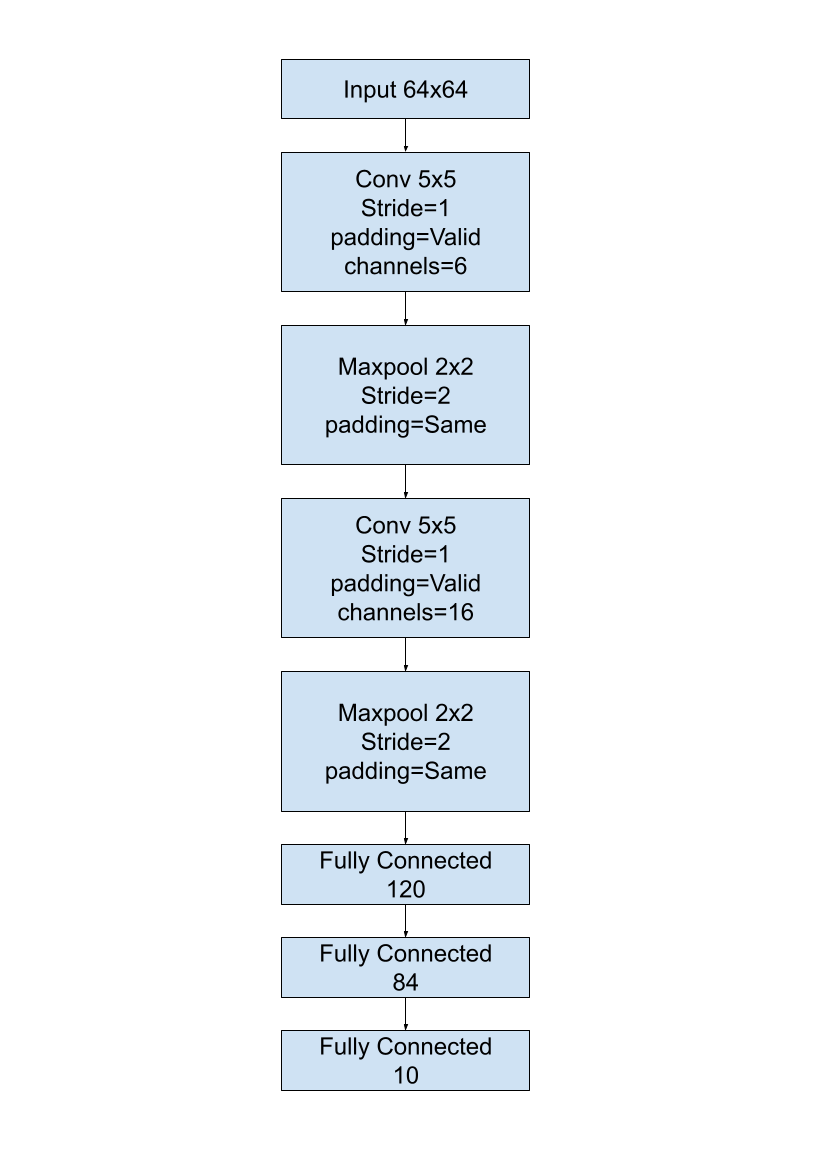

In [37]:
#Code Here

input_shape = (64, 64, 3)
num_classes = 10

inputs = tf.keras.Input(shape=input_shape)

# Conv 5x5, stride=1, padding=valid, channels=6
x = tf.keras.layers.Conv2D(6, kernel_size=(5,5), strides=1, padding="valid", activation="relu", name="first_conv")(inputs)

# Maxpool 2x2, stride=2, padding=same
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="same")(x)

# Conv 5x5, stride=1, padding=valid, channels=16
x = tf.keras.layers.Conv2D(16, kernel_size=(5,5), strides=1, padding="valid", activation="relu", name="second_conv")(x)

# Maxpool 2x2, stride=2, padding=same
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="same")(x)

# Flatten before Dense
x = tf.keras.layers.Flatten()(x)

# Fully connected layers
x = tf.keras.layers.Dense(units=120, activation="relu")(x)
x = tf.keras.layers.Dense(units=84, activation="relu")(x)

# Output layer
pred = tf.keras.layers.Dense(units=num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=pred)


## 3. Define the Loss Function, Optimizer and Metrics
define a categorical cross-entropy loss, an Adam optimizer and accuracy metric for training and validation.

In [38]:
#Code Here
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

## 4. Training Loop
Write a custom training and evaluation loop and store training and validation loss and training and validation accuracy of each epoch in a list:

In [39]:
def perform_validation():
    val_losses = []

    for x_val, y_val in test_ds:
        val_pred = model(x_val, training=False)
        val_loss = loss_fn(y_val, val_pred)
        val_losses.append(val_loss)
        val_acc_metric.update_state(y_val, val_pred)

    return tf.reduce_mean(val_losses)

In [40]:
# Define the number of epochs and the batch size
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Iterate over the number of epochs
for epoch in range(num_epochs):
    #Code Here
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    batch_losses = []

    # -------- TRAINING --------
    for x_batch, y_batch in train_ds:
        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)
            loss = loss_fn(y_batch, y_pred)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        batch_losses.append(loss)
        train_acc_metric.update_state(y_batch, y_pred)

    epoch_train_loss = tf.reduce_mean(batch_losses)
    epoch_train_acc = train_acc_metric.result()

    # -------- VALIDATION --------
    epoch_val_loss = perform_validation()
    epoch_val_acc = val_acc_metric.result()

    # -------- STORE --------
    train_losses.append(epoch_train_loss.numpy())
    train_accuracies.append(epoch_train_acc.numpy())
    val_losses.append(epoch_val_loss.numpy())
    val_accuracies.append(epoch_val_acc.numpy())

    print(
        f"Train Loss: {epoch_train_loss:.3f}, "
        f"Train Acc: {epoch_train_acc:.3f}, "
        f"Val Loss: {epoch_val_loss:.3f}, "
        f"Val Acc: {epoch_val_acc:.3f}"
    )

    # -------- RESET METRICS --------
    train_acc_metric.reset_state()
    val_acc_metric.reset_state()


Epoch 1/10
Train Loss: 1.416, Train Acc: 0.447, Val Loss: 1.048, Val Acc: 0.615

Epoch 2/10
Train Loss: 1.000, Train Acc: 0.639, Val Loss: 0.844, Val Acc: 0.691

Epoch 3/10
Train Loss: 0.807, Train Acc: 0.707, Val Loss: 0.724, Val Acc: 0.747

Epoch 4/10
Train Loss: 0.715, Train Acc: 0.736, Val Loss: 0.700, Val Acc: 0.759

Epoch 5/10
Train Loss: 0.640, Train Acc: 0.765, Val Loss: 0.720, Val Acc: 0.753

Epoch 6/10
Train Loss: 0.590, Train Acc: 0.783, Val Loss: 0.948, Val Acc: 0.719

Epoch 7/10
Train Loss: 0.539, Train Acc: 0.804, Val Loss: 0.925, Val Acc: 0.724

Epoch 8/10
Train Loss: 0.496, Train Acc: 0.818, Val Loss: 0.990, Val Acc: 0.731

Epoch 9/10
Train Loss: 0.451, Train Acc: 0.835, Val Loss: 0.871, Val Acc: 0.747

Epoch 10/10
Train Loss: 0.403, Train Acc: 0.851, Val Loss: 0.942, Val Acc: 0.734


## 5. Plot the training and validation loss and accuracy curves using matplotlib.


In [41]:
def plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    #Code Here
    epochs = range(1, len(train_losses) + 1)

    # -------- Loss Plot --------
    plt.figure()
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # -------- Accuracy Plot --------
    plt.figure()
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

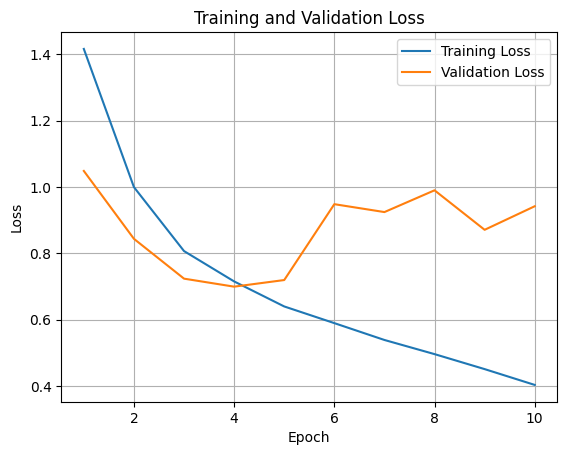

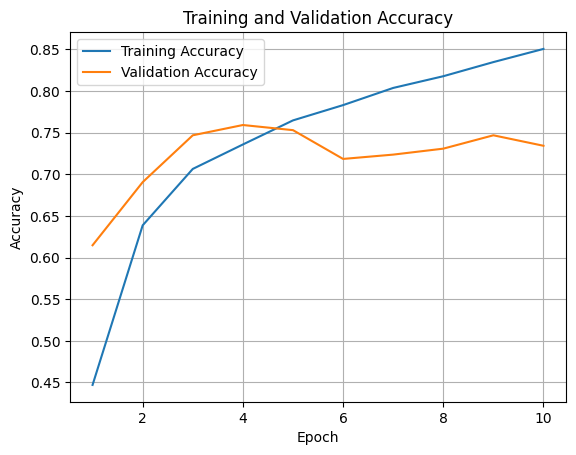

In [42]:
plot_loss_and_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)